In [1]:
##Create train, dev/val,test
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

### **Exercise 1** 

Task: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

In [8]:

words = open('names.txt', 'r').read().splitlines()
random.seed(42)
random.shuffle(words)

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

#Building the dataset - very similar to the trigram construction but dynamic
def prepare_data(data, block_size):

    block_size = block_size #alternative for context length

    X, Y = [], []

    for w in data:

        #print(w, '--- word of interest')
        context = [0] * block_size #How many characters to consider from the left to the right
        for ch in w + '.': #adding end word
            
            ix = stoi[ch]

            X.append(context)
            Y.append(ix)

            #print(''.join(itos[i] for i in context), '--->', itos[ix])

            context = context[1:] + [ix] #context is redefined as a new list and we move the window to the right


    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

train_limit = int(0.8*len(words))
dev_limit = int(0.9*len(words))
block_size = 3

Xtr, Ytr = prepare_data(words[:train_limit], block_size = block_size)
Xdev, Ydev = prepare_data(words[train_limit:dev_limit], block_size = block_size)
Xtest, Ytest = prepare_data(words[dev_limit:], block_size = block_size)

In [9]:
vocab_size = len(stoi)
embedding_dim = 10
n_hidden = 200
g = torch.Generator().manual_seed(2147483647)

In [27]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.fan_in = fan_in
    self.fan_out = fan_out
    self.weight = torch.randn((self.fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(self.fan_out) if bias else None

  
  def __call__(self, x):

    #Forward pass
    self.out = x @ self.weight

    #Adding the biases if needed
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def __repr__(self):
      """Prints the class representation."""
      if self.bias is None:
          return f"{self.__class__.__name__}(fan_in={self.fan_in}, fan_out={self.fan_out}, bias={False})"
      return f"{self.__class__.__name__}(fan_in={self.fan_in}, fan_out={self.fan_out}, bias={True})"
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias]) #learnable parameters


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):

    #Epsilon is a small value used for preventing the perfect nullity of variance
    self.eps = eps
    self.momentum = momentum
    self.training = True
    self.dim = dim
    # parameters (trained with backprop)
    self.gamma = torch.ones(self.dim)
    self.beta = torch.zeros(self.dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(self.dim)
    self.running_var = torch.ones(self.dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
      
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def __repr__(self):
    """Prints the class representation."""
        
    return f"{self.__class__.__name__}(dim={self.dim}, eps={self.eps}, momentum={self.momentum}, training={self.training})"
  

  def parameters(self):
    return [self.gamma, self.beta] #learnable parameters

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def __repr__(self):
    """Prints the class representation."""
        
    return f"{self.__class__.__name__}()"
  

  def parameters(self):
    return []

In [11]:

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=True), BatchNorm1d(vocab_size),
]


with torch.no_grad():
  # last layer: make less confident
  #layers[-1].gamma *= 0.1 #When using batch norm; makes layer less confident?
  #layers[-1].weight *= 0.1 #artificially makes outer layer less confident. 
  
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 0
      #layer.weight *= 5/3 #1.0 #5/3 ###gain section
      
    

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

174751


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
    
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # This is for gathering stats below. When done with debugging we can turn this off.

  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters]) #update to data ratio. How much are gradients changing (given learning rate influence) per absolute change in data  

  if i >= 5000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2958


### Activation Distribution

- We can now vizualize the forward pass activations, namely, activations from the Tanh layer, since this activation function like other activation functions squashes the inputs between -1 and 1 so it is fairly easy to vizualize what is happening at the output of each layer. As will be shown below, we will keep track of not only mean and scale of these activations but also of the tanh saturation rates.

layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

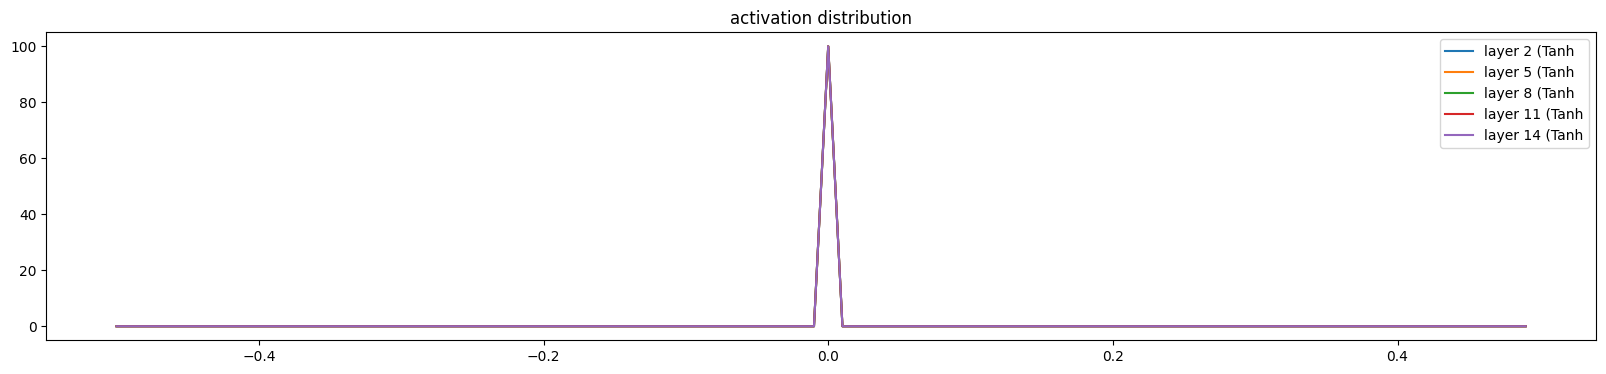

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):  #Only looking at tanh layers
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

#### Gradient Distribution
- look at distribution of tanh layer activations 

layer 2 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00
layer 8 (      Tanh): mean +0.000000, std 0.000000e+00
layer 11 (      Tanh): mean +0.000000, std 0.000000e+00
layer 14 (      Tanh): mean +0.000000, std 0.000000e+00


Text(0.5, 1.0, 'gradient distribution')

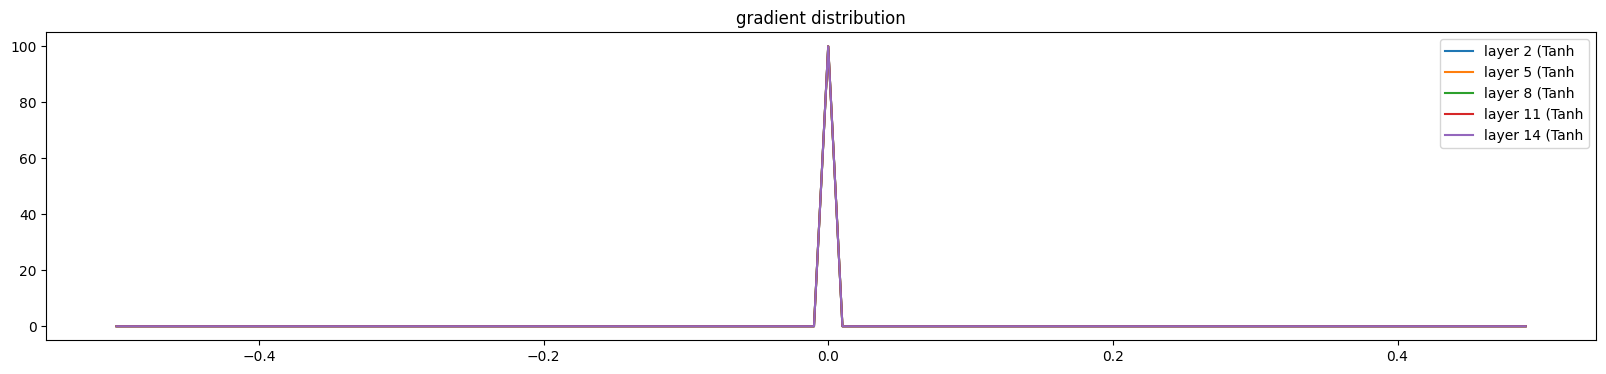

In [14]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

### Weights and gradient distribution

It is possible to do the same thing with the gradients of weights where we can also compute the so-called gradient-to-data ratios which enable comparing the scale of the gradients of the parameter values to the scale of the parameter values themselves.

weight   (27, 10) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00
weight  (30, 200) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (200, 200) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (200, 200) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (200, 200) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (200, 200) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight  (200, 27) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan


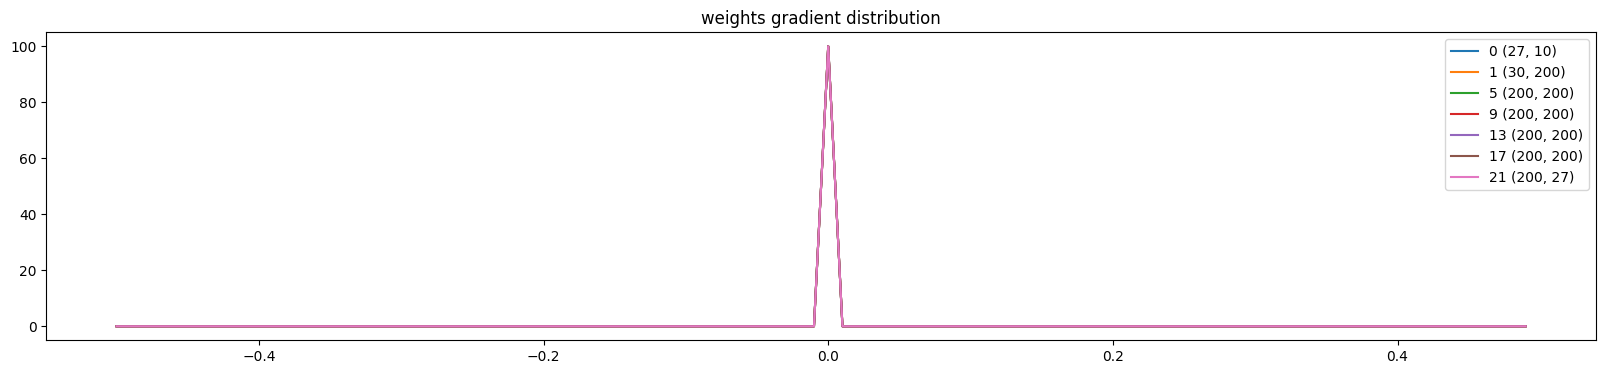

In [19]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  
  if p.ndim == 2: #only looking at weights here based on ndim filter here.
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

#### Visualizing update-to-data ratio
- The statistic gradient-to-data we have been using above is not in fact that informative: what we would actually like to know is how the actual update (learning rate multiplied by the gradient) relates to the the values getting updated (see calculation in the training loop above).

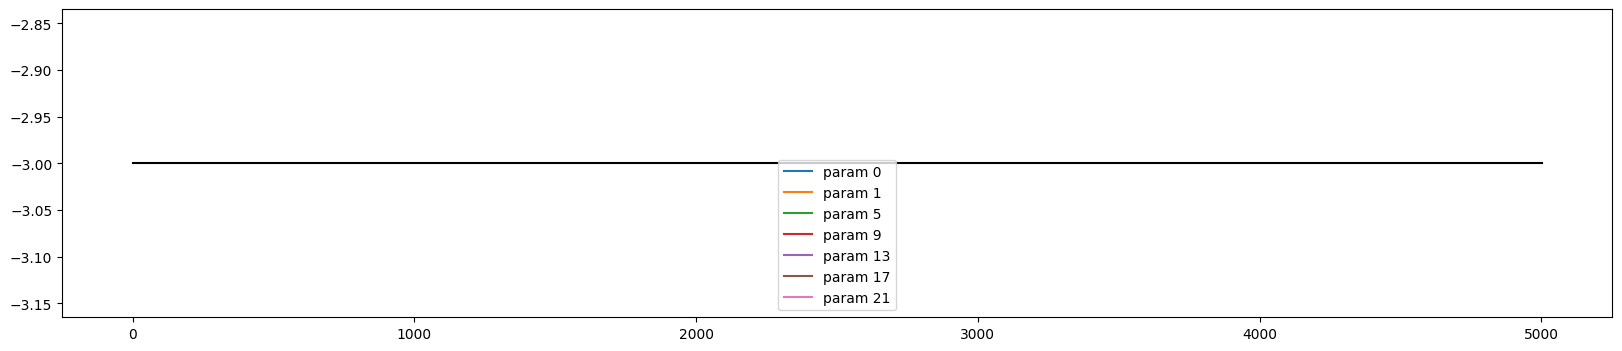

In [16]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [17]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

/var/folders/9j/6jx2ypd90v7fxy19gd_2tz3c0000gn/T/ipykernel_47792/1079421579.py:36: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  xvar = x.var(0, keepdim=True) # batch variance


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

The experiment where we set all weights and biases to zero produces no learning throughout the layer. The reason for this is because no learning is possible when weights and biases are set to zero. No matter gradient change nothing is being learned. 

______________________

### **Exercise 2** 
 

Task: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

In [28]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=True), BatchNorm1d(vocab_size),
]

for layer in layers:
    print(layer)
    if isinstance(layer, Tanh):
        print()

Linear(fan_in=30, fan_out=200, bias=True)
BatchNorm1d(dim=200, eps=1e-05, momentum=0.1, training=True)
Tanh()

Linear(fan_in=200, fan_out=200, bias=True)
BatchNorm1d(dim=200, eps=1e-05, momentum=0.1, training=True)
Tanh()

Linear(fan_in=200, fan_out=200, bias=True)
BatchNorm1d(dim=200, eps=1e-05, momentum=0.1, training=True)
Tanh()

Linear(fan_in=200, fan_out=27, bias=True)
BatchNorm1d(dim=27, eps=1e-05, momentum=0.1, training=True)


In [29]:
with torch.no_grad():
  layers[-1].gamma *= 0.1 #When using batch norm; makes layer less confident?
  #layers[-1].weight *= 0.1 #artificially makes outer layer less confident. 
  
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      #layer.weight *= 0
      layer.weight *= 5/3 #1.0 #5/3 ###gain section
      
    
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

93551


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
    
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # This is for gathering stats below. When done with debugging we can turn this off.

  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters]) #update to data ratio. How much are gradients changing (given learning rate influence) per absolute change in data  

  if i >= 5000:
    break # AFTER_DEBUG: would take out obviously to run full optimization